In [1]:
from load_dataset import load_diabetes_dataset
from model_manager import PytorchModelManager
from cf_engine.engine import CFEnginePytorch
from cf_engine.counterfactual import CounterfactualExampleBySubset

In [2]:
import numpy as mp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [3]:
from torch.utils.data import TensorDataset
import torch

dataset = load_diabetes_dataset()
mm = PytorchModelManager(dataset, model_name='MLP_Glucose>0')
dm = mm.get_dir_manager()
feature_names = dataset.get_feature_names()
target_names = dataset.get_target_names()
try:
    mm.load_model()
except FileNotFoundError:
    train_dataset = dataset.get_train_dataset(False)
    train_dataset = train_dataset[train_dataset['Glucose'] >= 1]
    train_dataset = dataset.preprocess(train_dataset)
    train_x = torch.from_numpy(train_dataset[feature_names].values).float()
    train_y = torch.from_numpy(train_dataset[target_names].values).float()
    train_dataset = TensorDataset(train_x, train_y)
    mm.train(train_dataset)
    mm.save_model()
# mm.train()
engine = CFEnginePytorch(mm, dataset)

In [6]:
target_name = dataset.get_target_names(False)
pre_target_name = '{}_pred'.format(target_name)
desc = dataset.get_description()
neg = desc[target_name]['category'][0]
pos = desc[target_name]['category'][1]
def plot_subset_cf(subset_attr_cf):
    for i, (feature, subset_cf) in enumerate(subset_attr_cf.items()):
        cf_df = subset_cf.get_cf().reset_index(drop=True)
        original_df = subset_cf.get_instance().reset_index(drop=True)
#         valid_index = cf_df[pre_target_name] != \
#             original_df.loc[cf_df['OriginIndex'], pre_target_name]
#         valid_cf = cf_df.loc[valid_index, :]
#         valid_instance = original_df.loc[valid_cf['OriginIndex'], :]
        valid_index = cf_df[pre_target_name] != original_df[pre_target_name]
        valid_cf = cf_df[valid_index]
        valid_instance = original_df[valid_index]
        pos_valid_cf_attr_value = valid_cf[valid_cf[pre_target_name] == pos][feature]
        neg_valid_cf_attr_value = valid_cf[valid_cf[pre_target_name] == neg][feature]
        pos_valid_instance_attr_value = valid_instance[valid_instance[pre_target_name] == pos][feature]
        neg_valid_instance_attr_value = valid_instance[valid_instance[pre_target_name] == neg][feature]
        # add subplots
        plt.subplot(len(subset_attr_cf), 2, i*2+1)
        plt.hist(neg_valid_instance_attr_value, bins=25, alpha=0.5, label='neg', color='b')
        plt.hist(pos_valid_cf_attr_value, bins=25, alpha=0.5, label='pos', color='r')
        plt.legend(loc='upper right')
        plt.title('{}: neg->pos'.format(feature))
        plt.subplot(len(subset_attr_cf), 2, i*2+2)
        plt.hist(pos_valid_instance_attr_value, bins=25, alpha=0.5, label='pos', color='r')
        plt.hist(neg_valid_cf_attr_value, bins=25, alpha=0.5, label='neg', color='b')
        plt.legend(loc='upper right')
        plt.title('{}: pos->neg'.format(feature))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

[49/49]  Epoch-0, time cost: 0.665s, loss: 0.592, iteration: 361, validation rate: 0.143
Total time cost: 0.704, validation rate: 0.143, average distance: 1.251, average loss: 0.592
[49/49]  Epoch-0, time cost: 0.489s, loss: 0.590, iteration: 247, validation rate: 1.000
Total time cost: 0.534, validation rate: 1.000, average distance: 1.208, average loss: 0.590
[49/49]  Epoch-0, time cost: 1.216s, loss: 0.522, iteration: 875, validation rate: 0.286
Total time cost: 1.258, validation rate: 0.286, average distance: 1.288, average loss: 0.522
[49/49]  Epoch-0, time cost: 0.642s, loss: 0.672, iteration: 342, validation rate: 0.184
Total time cost: 0.685, validation rate: 0.184, average distance: 1.390, average loss: 0.672
[49/49]  Epoch-0, time cost: 0.904s, loss: 0.499, iteration: 579, validation rate: 0.184
Total time cost: 0.948, validation rate: 0.184, average distance: 1.231, average loss: 0.499
[49/49]  Epoch-0, time cost: 0.461s, loss: 0.654, iteration: 263, validation rate: 1.000
T

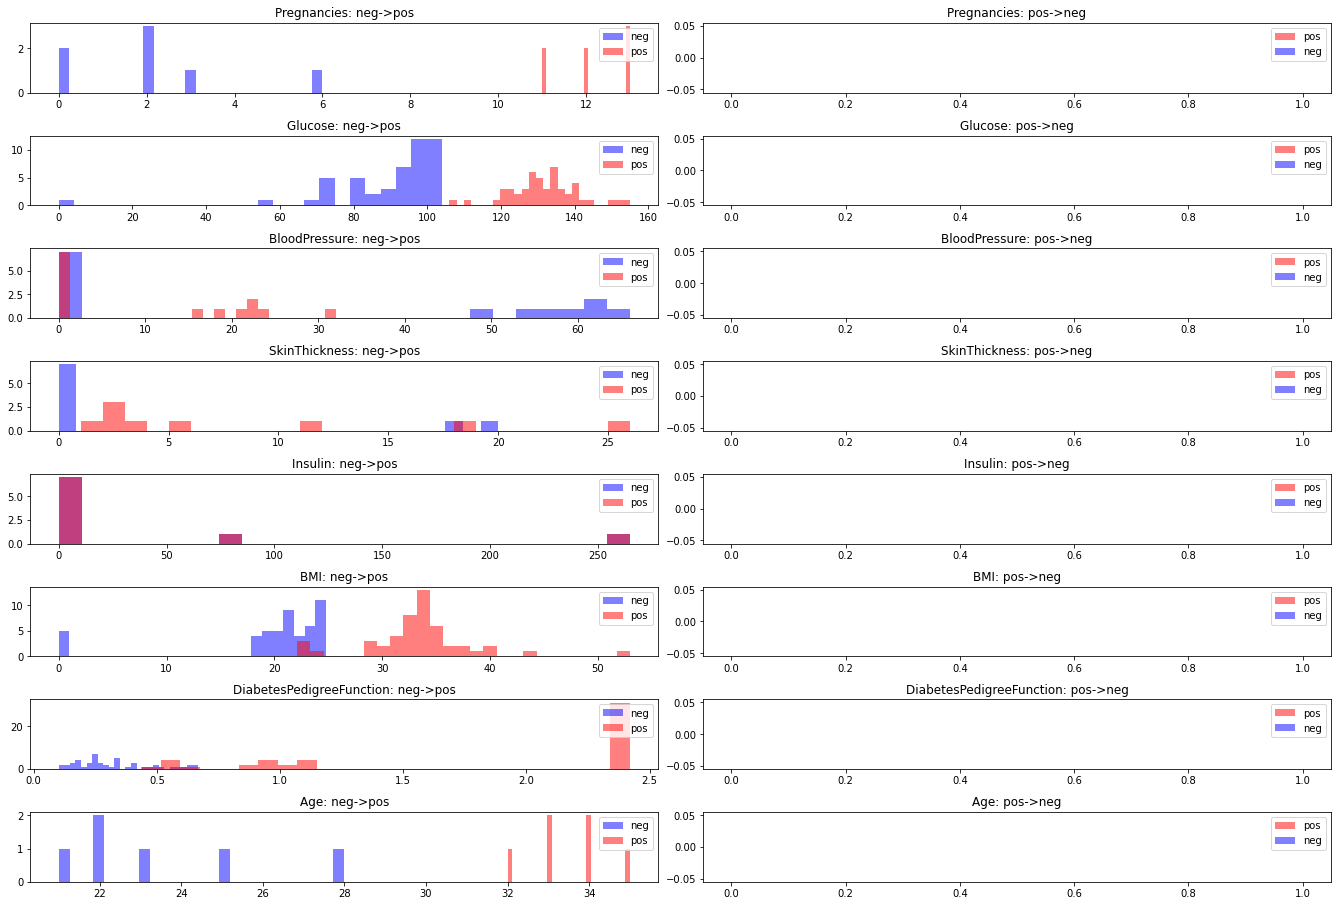

In [9]:
subset = {'Glucose': {'max': 105, 'min': 0}, 'BMI': {'max': 25, 'min': 0}, 
          'Age': {'max': 30, 'min': 0}, 'DiabetesPedigreeFunction': {'max': 0.7, 'min': 0}}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=128, post_step=10, max_iter=5000, use_cache=False)
fig = plt.gcf()
fig.set_size_inches(18.5, 12.5)
plot_subset_cf(subset_attr_cf)